In [1]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.8.0


In [2]:
!sudo pip3 install keras

In [3]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools

In [4]:
# !wget -nc https://lazyprogrammer.me/course_files/blood_cell_images.zip

In [5]:
# !unzip -nq blood_cell_images.zip

unzip:  cannot find or open blood_cell_images.zip, blood_cell_images.zip.zip or blood_cell_images.zip.ZIP.


In [6]:
# Re-size all the images to this
image_size = [224, 224] 

# Training config:
epochs = 16
batch_size = 28

In [7]:
train_path = "blood_cell_images/TRAIN"
valid_path = "blood_cell_images/TEST"

In [8]:
# Useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# Useful for getting number of classes
folders = glob(train_path + '/*')

Text(0.5, 1.0, 'LYMPHOCYTE')

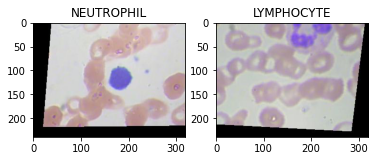

In [9]:
# Looking at a random image 
plt.subplot(1,2,1)
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.title(f"{np.random.choice(image_files)[24:34]}")

plt.subplot(1,2,2)
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.title(f"{np.random.choice(image_files)[24:34]}")

In [10]:
# Resnet 
res = ResNet50(
    input_shape=image_size + [3], 
    weights='imagenet', 
    include_top=False)

# Don't train existing weights
for layer in res.layers:
  layer.trainable = False

In [11]:
# Layers
x = Flatten()(res.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [12]:
# Creating model
model = Model(inputs=res.input, outputs=prediction)

# Summary
model.summary()

# Model parameters
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [13]:
# Creating an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input)

In [14]:
# Test generator to see how it works and some other useful things

# Get label mapping for confusion matrix plot later
test_gen = val_gen.flow_from_directory(valid_path, target_size=image_size)
print(test_gen.class_indices)

labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -123.68 max: 151.061


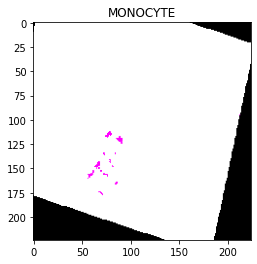

In [15]:
# Images should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [16]:
# Creating generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=image_size,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse')

valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=image_size,
  shuffle=False,
  batch_size=batch_size,
  class_mode='sparse')

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [24]:
# Fitting the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size)

Epoch 1/16
355/355 [==============================] - 192s 502ms/step - loss: 9.9999 - accuracy: 0.5322 - val_loss: 8.9644 - val_accuracy: 0.5499
Epoch 2/16
355/355 [==============================] - 177s 499ms/step - loss: 7.8131 - accuracy: 0.6663 - val_loss: 11.2236 - val_accuracy: 0.5588
Epoch 3/16
355/355 [==============================] - 177s 497ms/step - loss: 6.7284 - accuracy: 0.7237 - val_loss: 17.0354 - val_accuracy: 0.5008
Epoch 4/16
355/355 [==============================] - 179s 503ms/step - loss: 7.2402 - accuracy: 0.7379 - val_loss: 15.0684 - val_accuracy: 0.5812
Epoch 5/16
355/355 [==============================] - 176s 494ms/step - loss: 5.8869 - accuracy: 0.7716 - val_loss: 15.6465 - val_accuracy: 0.5836
Epoch 6/16
355/355 [==============================] - 177s 497ms/step - loss: 5.8653 - accuracy: 0.7850 - val_loss: 20.3726 - val_accuracy: 0.5329
Epoch 7/16
355/355 [==============================] - 177s 499ms/step - loss: 5.2418 - accuracy: 0.8094 - val_loss: 15.

In [25]:
from tensorflow.keras.models import load_model
model.save('model_resnet.h5')

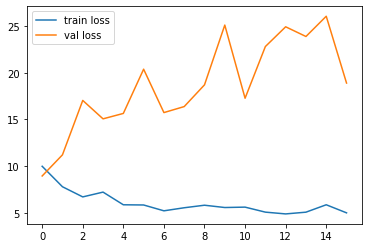

In [26]:
# Loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

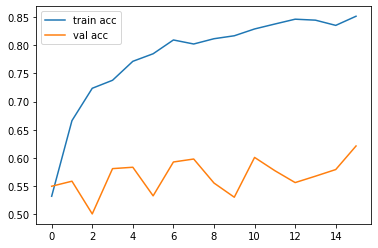

In [27]:
# Accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [28]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  n_images = 0
  for x, y in val_gen.flow_from_directory(
      data_path,
      target_size=image_size,
      shuffle=False,
      batch_size=batch_size * 2):
    i += 1
    n_images += len(y)
    if i % 50 == 0:
      print(f'{n_images} images processed.')
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [29]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 9957
Found 9957 images belonging to 4 classes.
2800 images processed.
5600 images processed.
8400 images processed.
[[2268  103   59   67]
 [   8 2468    3    4]
 [   1   15 2460    2]
 [ 255  157  127 1960]]


In [30]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
[[316 114  67 126]
 [ 75 484  39  22]
 [170  16 347  87]
 [134  57  37 396]]


In [57]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap="BuPu"):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.figure(figsize=(15, 15))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Normalized confusion matrix
[[9.08289948e-01 4.12494994e-02 2.36283540e-02 2.68321986e-02]
 [3.22190898e-03 9.93958921e-01 1.20821587e-03 1.61095449e-03]
 [4.03551251e-04 6.05326877e-03 9.92736077e-01 8.07102502e-04]
 [1.02040816e-01 6.28251301e-02 5.08203281e-02 7.84313725e-01]]


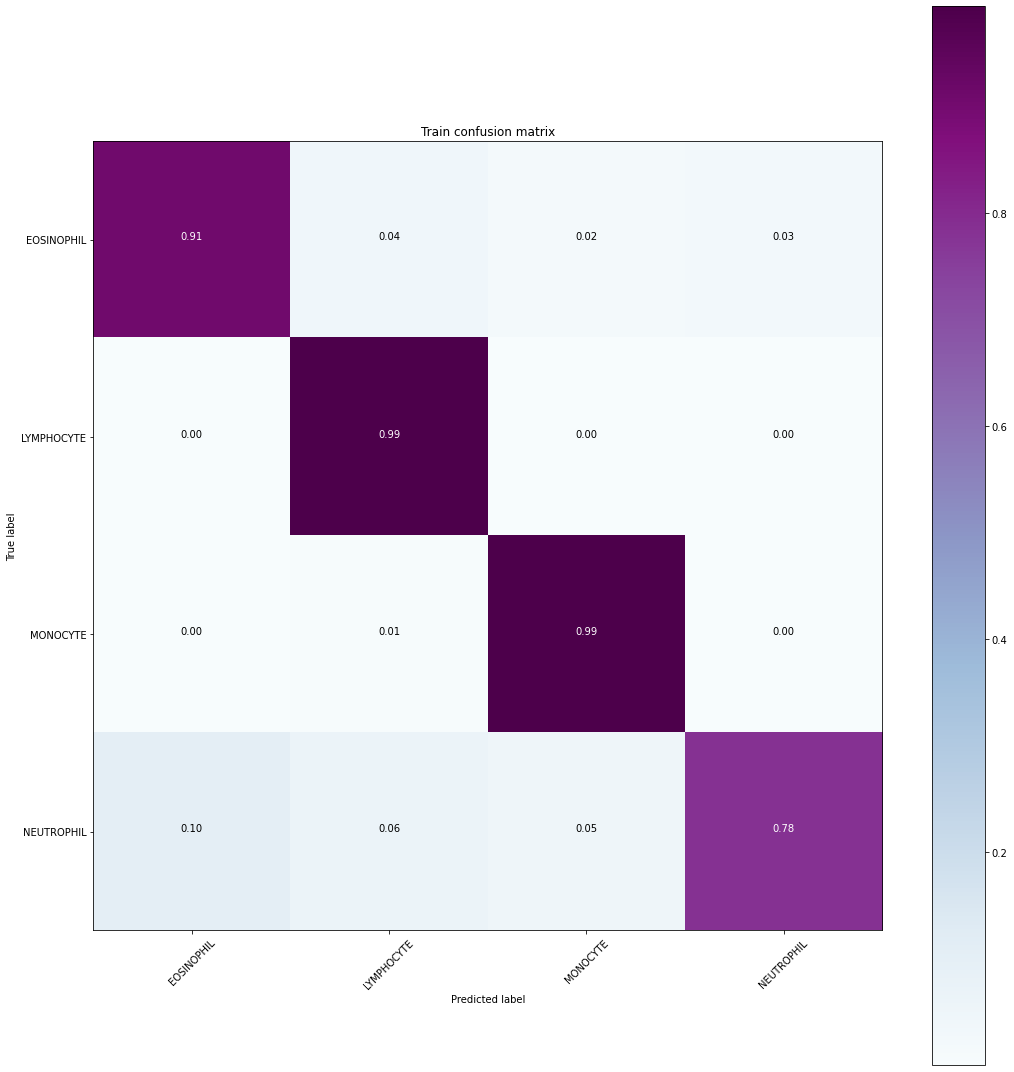

In [58]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix', normalize=True)

In [62]:
np.trace(cm) / cm.sum()

0.9195540825549865

Normalized confusion matrix
[[0.50722311 0.18298555 0.10754414 0.20224719]
 [0.12096774 0.78064516 0.06290323 0.03548387]
 [0.27419355 0.02580645 0.55967742 0.14032258]
 [0.21474359 0.09134615 0.05929487 0.63461538]]


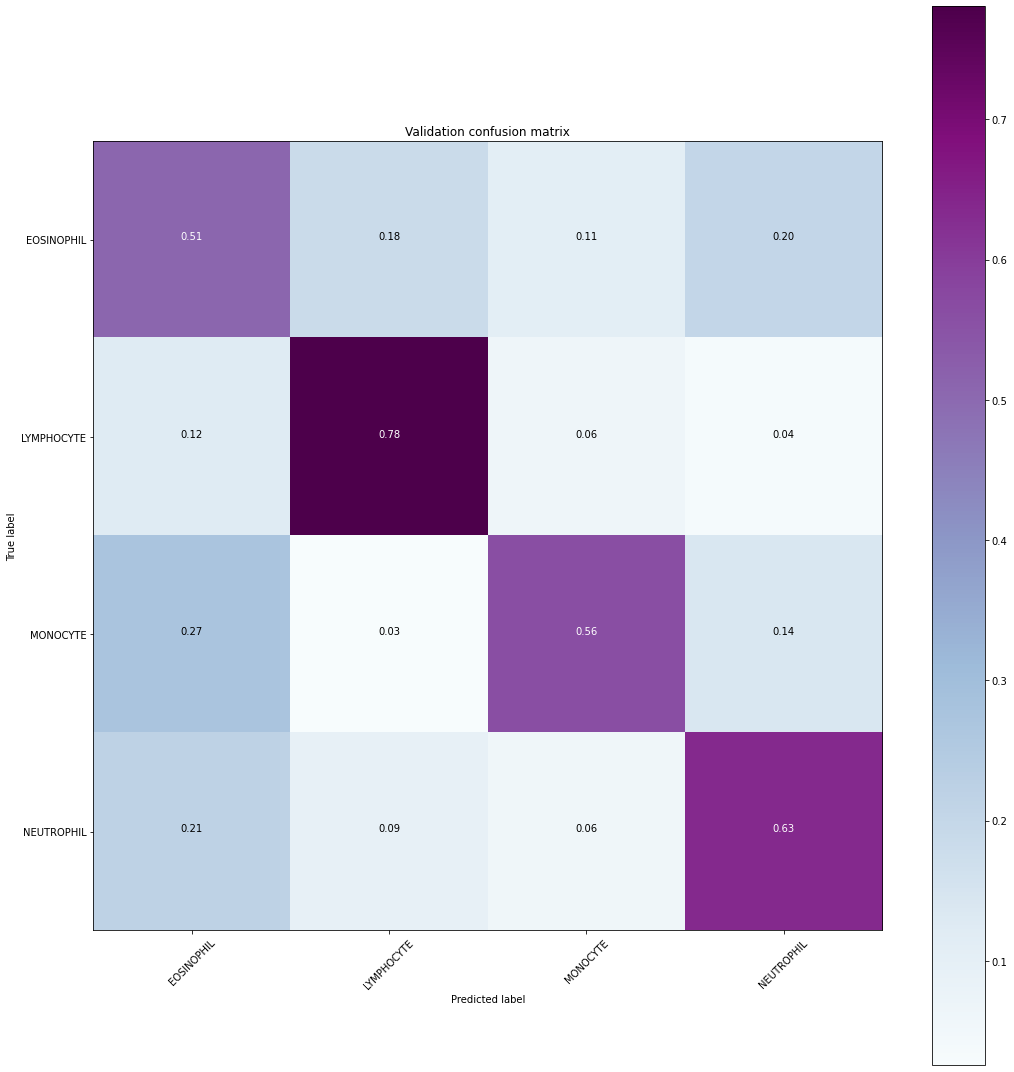

In [59]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix', normalize=True)

In [42]:
np.trace(valid_cm) / valid_cm.sum()

0.6204262163248895

In [43]:
test_simple = "blood_cell_images/TEST_SIMPLE"
image_files = glob(test_simple + '/*/*.jp*g')
folders = glob(test_simple+ '/*')

In [44]:
test_simple_gen = val_gen.flow_from_directory(test_simple, target_size=image_size)
print(test_gen.class_indices)

labels = [None] * len(test_simple_gen.class_indices)
for k, v in test_simple_gen.class_indices.items():
  labels[v] = k

Found 71 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


In [47]:
predictions_simple = np.argmax(model.predict(test_simple_gen), axis=1)

In [49]:
simple_cm = get_confusion_matrix(test_simple, len(image_files))
print(simple_cm)

Generating confusion matrix 71
Found 71 images belonging to 4 classes.
[[ 7  0  0  6]
 [ 0  4  0  2]
 [ 1  0  1  2]
 [ 6  1  0 41]]


Normalized confusion matrix
[[0.53846154 0.         0.         0.46153846]
 [0.         0.66666667 0.         0.33333333]
 [0.25       0.         0.25       0.5       ]
 [0.125      0.02083333 0.         0.85416667]]


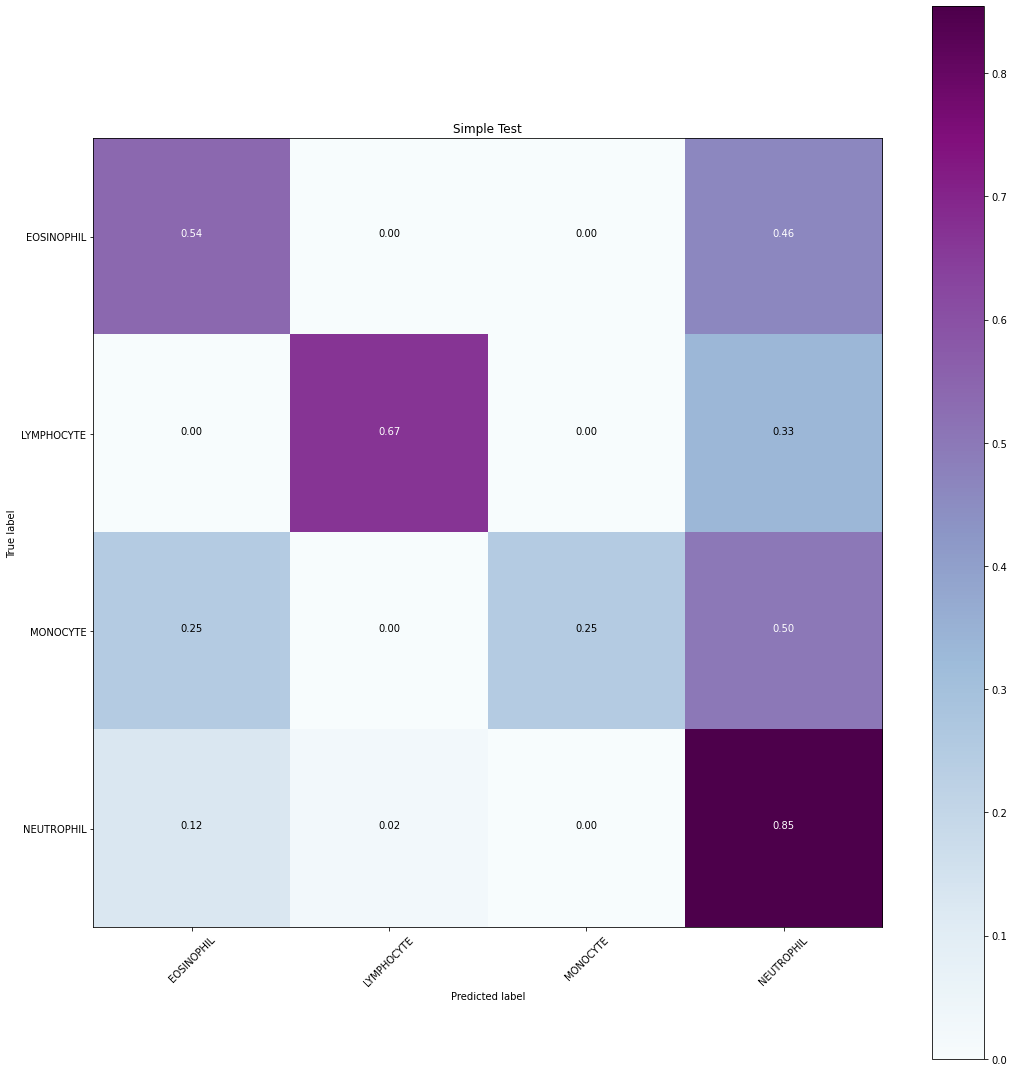

In [60]:
plot_confusion_matrix(simple_cm,labels, normalize=True, title="Simple Test")

In [61]:
np.trace(simple_cm) / simple_cm.sum()

0.7464788732394366